## linearized Bregman iteration with fixed stepsize

minimize $|x|_1 + \frac{1}{(2*alpha)} |x|_2^2$

subject to $Ax = b$

input: 
- A: constraint matrix
- b: constraint vector
- alpha: smoothing parameter, typical value: 1 to 10 times estimated norm(x,inf)
- opts.
 - stepsize: dual ascent stepsize, see below
 - tol: stop iteration once norm(Ax-b)<tol*norm(b), default: 1e-4
 - maxit: max number of iterations, default: 3000
 - maxT:  max running time in second, default: 1000
 - x_ref: if provided, norm(x^k - x_ref) is computed and saved in out.hist_err, default: []

output:
- x: solution vector
- out.
 - iter: number of iterations
 - hist_obj: objective value at each iteration
 - hist_res: $|Ax-b|_2$ at each iteration
 - hist_err: if opts.x_ref is provided, contains norm(x^k - x_ref); otherwise, will be set to []

Algorithm:
- Linearized Bregman is the dual gradient ascent iteration.
- The dual problem is: $b'y - \frac{alpha}{2} |shrink(A'y,1)|^2$,  
  where $shrink(z,1) = z - proj_{[-1,1]}(z) = sign(z).*max(abs(z)-1,0)$

Let y be the dual variable. The iteration is 
- $y^{k+1} = y^k + stepsize (b - alpha*A * shrink(A'y^k,1))$

Primal variable x is obtained as 
- $x^k = alpha * shrink(A'y^k,1)$

%
% How to set alpha:
%   There exists alpha0 so that any alpha >= alpha0 gives the solution to minimize |x|_1 subject to Ax = b.
%   The alpha depends on the data, but a typical value is 1 to 10 times the estimate of norm(solution_x,inf)
%
% How to set opts.stepsize:
%   Too large will cause divergence; too small will cause slow convergence.
%   A conservative value is 1.99/alpha/norm(A)^2, which guarantees convergence.
%   If norm(A)^2 is expensive to compute, one can compute norm(A*A') or norm(A'*A) (choose the easier one!),
%   or use the method in arXiv:1104.2076.
%   If opts.stepsize is not set, then the code uses 2/alpha/normest(A*A',1e-2)
%
% How is the algorithm stopped: see "% stopping" below
%
% More information can be found at

% http://www.caam.rice.edu/~optimization/linearized_bregman

In [48]:
function [x,out] = lbreg_fixedstep(A,b,alpha,opts)

if isfield(opts,'stepsize'),  stepsize = opts.stepsize;  else stepsize = 1.99/alpha/normest(A*A',1e-2); end
if isfield(opts,'tol'),    tol = opts.tol;     else tol = 1e-4;   end
if isfield(opts,'maxit'),  maxit = opts.maxit; else maxit = 500;  end
if isfield(opts,'maxT'),   maxT = opts.maxT;   else maxT = 1e3;   end
if isfield(opts,'x_ref'),  x_ref = opts.x_ref; else x_ref = []; out.out.hist_err = [];  end

m = size(A,1);

y = zeros(m,1);
res = b; % residual (b - Ax)
norm_b = norm(b);

shrink = @(z) sign(z).*max(0,abs(z)-1);

start_time = tic;

for k = 1:maxit

    % --- y-update ---
    y = y + stepsize * res; % for k=1, (stepsize + 1/max(abs(b.'*A))) can be used as stepsize

    % --- x-update ---
    x = alpha * shrink(y.'*A).';
    Ax = A*x;
    res = b - Ax; % res will be used in next y-update

    % --- diagnostics, reporting, stopping checks ---
    % reporting
    out.hist_obj(k) = b.'*y - norm(x)^2/alpha/2; % dual objective
    out.hist_res(k) = norm(res); % residual size |b - Ax|_2
    if ~isempty(x_ref); out.hist_err(k) = norm(x - x_ref); end

    % stopping
    if toc(start_time) > maxT; break; end; % running time check
    if k > 1
        % dual objective check
        obj_diff = out.hist_obj(k) - out.hist_obj(k-1);
        if obj_diff < -1e-10; error('dual objective decreases; opts.stepsize is too large!'); end
        % primal residual check
        if norm(res) < tol*norm_b; break; end
    end
end

out.iter = k;

end

In [51]:
pkg install -forge statistics

For information about changes from previous versions of the statistics package, run 'news statistics'.


time = 3.46e-02, solution relative error = 1.41e-04



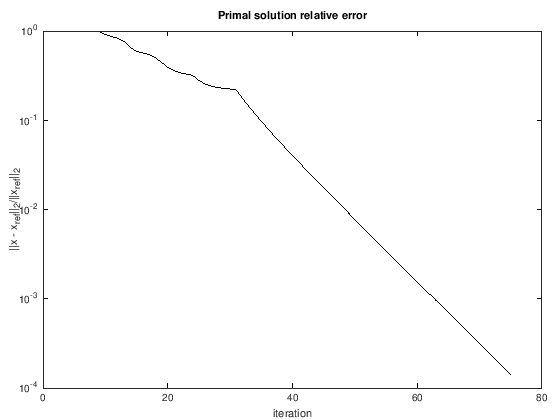

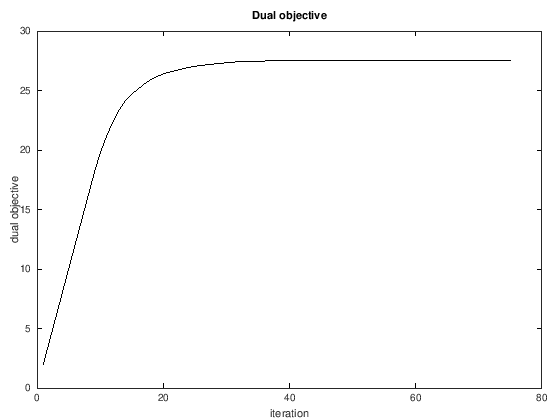

In [53]:
% An example of recovery a sparse solution x from Ax = b using linearized Bregman iteration with a fixed stepsize
% The nonzero entries of x equal 1

%% Generate problem data
pkg load statistics

rand('seed', 0); randn('seed', 0);

m = 250; n = 500; % matrix dimension m-by-n
k = 25; % sparsity

A = randn(m,n); % random matrix
x_ref = zeros(n,1); % true vector
x_ref(randsample(n,k)) = 1;
b = A*x_ref; % finish generating equations Ax = b

%% Solve problem
alpha = 5*norm(x_ref,inf); % don't need to be exact, roughly 1 - 10 times norm(x_ref,inf) is fine
opts.stepsize = 2/alpha/normest(A*A.',1e-2); % roughly 2/alpha/norm(A)^2
opts.tol = 1e-4; % stop once norm(Ax-b)<tol*norm(b)
opts.x_ref = x_ref;

t0 = tic;
[x,out] = lbreg_fixedstep(A,b,alpha,opts);
time = toc(t0);

%% Reporting
fprintf('time = %4.2e, ', time);
fprintf('solution relative error = %4.2e\n\n', norm(x - x_ref)/norm(x_ref));

figure;
plot(1:out.iter, out.hist_obj, 'k-', 'LineWidth', 2);
title('Dual objective')
xlabel('iteration'); ylabel('dual objective');

figure;
semilogy(1:out.iter, out.hist_err/norm(x_ref), 'k-', 'LineWidth', 2);
title('Primal solution relative error')
xlabel('iteration'); ylabel('||x - x_{ref}||_2/||x_{ref}||_2');

%% <http://www.caam.rice.edu/~optimization/linearized_bregman/fixed_step/example_binary_sol.m Download this m-file>